
## Amazon Web Services

# Machine Learning to Develop Business Strategies

_**Machine Learning combined with sensitivity analysis to develop customer churn strategies on AWS**_

https://aws.amazon.com/blogs/machine-learning/developing-a-business-strategy-by-combining-machine-learning-with-sensitivity-analysis/

---

---

# Contents

[Background](#Background)
<br> Business context and objective
    
1. [Data](#Data) 
<br> Data exploration and feature engineering 

1. [Modeling](#Modeling)
<br> Develop ensemble of ML models

1. [Evaluation](#Evaluation)
<br> Evaluate and refine ML model performance

1. [Application](#Application)
<br> Apply ML models and sensitivity analysis to design business strategy

[Addendum](#Addendum)
<br> Use same approach with an ensemble method to improve generalization



---

# Background

Machine learning is routinely used to help make business decisions yet most often, ML is only used to make predictions while business decisions require some judgement and intuition from experts.

In this notebook, ML predictions are combined with a *sensitivity analysis* to develop a data driven business strategy. 

Specifically, your goal will be to identify customers who will churn in a fictitious dataset made of features such as forecasted sales, marketing reach, products purchased, discount applied, and a churn label for each customer. Then you will use feature importance to identify factor that may impact churn. Finally you will modfify such factor to quantify how much improvement you can realistically expect on churn.


# Data

## 1. Data exploration and feature engineering
In this section, you'll look at simple correlations and associations between individual input features and the churn label, and between the features themselves (covariances). This step enables you to make algorithmic decisions, in particular which features to derive, delete and change. You'll compute the covariances before and after filtering for the strongest outliers to evaluate the impact of removing outliers. 

### 1.1 Read datasets and fill-in missing values 

In [41]:
# Import general Python libraries 
import numpy as np
import pandas as pd
import scipy as sc 
import math
import pdb 
import sys
import random
import matplotlib.pyplot as plt
import matplotlib as mpl
import pylab as lab

# Import preprocessing
from sklearn import preprocessing, utils
from sklearn.feature_selection import VarianceThreshold # Pre-feature selection (i.e. not recursive)
from datetime import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta # Used to correct renewal date which was off by 1 year 

# Import ML models
# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC  
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier # Ensemble with soft voting (= average predicted probability) 
from sklearn import kernel_ridge
from sklearn import linear_model

# Import feature selection
from sklearn.feature_selection import RFE,RFECV # Recursively prune features based on weights
from sklearn.model_selection import StratifiedKFold, GridSearchCV

# Import k-folding
from sklearn import model_selection # for k-folding
from sklearn.calibration import CalibratedClassifierCV

# Import accuracy measures
from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error, mean_squared_error, classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, brier_score_loss, roc_auc_score, roc_curve, auc

#########################################
#                                       #
#    Read data and derive new features  #
#                                       #
#########################################

# Arg #1: dataname      # has to be either 'training' or 'fcst'
# Arg #2: balance       # 1: Manually balance training data, 0: Don't 
pathIN = "../data/"     # Path where input csv files are located
pathOUT = "../out/"     # Path where fig/output files will be located 
balance = 1             # Set to 1 (apply class balancing) or 0 (don't apply)
dataname = 'training'   # Set to 'training' or 'forecast'

# CSV test filenames
locY = pathIN + 'training_labels.csv'
locfcstin = pathIN + 'forecast_unknownlabels.csv'
locfcstout = pathOUT + 'forecast_labels.csv'

# Set random number generator seed (make sure results are reproducible)
seed = 2017
np.random.seed(seed)

# Define function to transform simple categorical variables into binaries
def onehot(catfeatures):
    cat = pd.concat(catfeatures, axis=1) 
    cat = pd.get_dummies(cat)
    return cat

###################################
#                                 #
#    Read data from CSV file      #
#                                 #
###################################
 
data = pd.read_csv(pathIN + dataname + '_blog_data.csv')
Y = pd.read_csv(locY)

# Create matrix of categorical binary features
catfeat = pd.DataFrame(onehot([data['SalesChannel']]))
data = data.drop(['SalesChannel'], axis = 1)

#####################################
#                                   #
#   Drop features and fill-in NaN   #
#                                   #
#####################################

# Missing data, approach 1: Delete clients with NaN (for actual predictions, replace NaN by median value) 
# This approach is only used to identify useless features with lots of NaN, and check marginal correlations
nonan = data
nclients = len(nonan)
for col in nonan.columns:
    p = nonan[col].isnull().sum() / nclients
    if p > 0.4: 
        nonan = nonan.drop([col],axis=1) 
    else:
        k = 0; n = len(nonan) # len(nonan) will change as rows are deleted
        for i in range(0,n):
            if pd.isnull(nonan[col].iloc[i-k]):           
                nonan = nonan.drop(nonan.index[[i-k]])
                k += 1
print("Number of clients left after removing all NaN: ",len(nonan))

# Missing data, approach 2: Check proportions of NaN: if p > 0.4, delete. Otherwise replace NaN by median value.
nclients = len(data)
for col in data.columns:
    p = data[col].isnull().sum() / nclients
    if p > 0.4: 
        print("Too many NaN (>40%) - Deleting: ",col)
        data = data.drop([col],axis=1) 
    elif col != 'ID':
        med = data[col].median()
        for i in range(0,nclients):
            if pd.isnull(data[col].iloc[i]): 
                data.loc[i,col] = med

## Filter out binaries with very high sparsity ( = no variance across 90% observations) 
#sel = VarianceThreshold(threshold=(.95 * (1 - .95))) # p(1 - p) is the variance of a Bernoulli variable
#X = sel.fit_transform(catfeat.as_matrix())
#print("Number of features selected: {}".format(X.shape[1]))
#features_fs1 = pd.DataFrame(catfeat.columns[sel.get_support(indices=True)])
#print(features_fs1.values)

# Combine all numeric and categorical features
data_cat = pd.concat([data, catfeat], axis = 1)

# Merge with y based on ID, then remove ID to have fully numeric dataframe
if dataname == 'training':
    data = pd.merge(data, Y, how='inner', on=['ID'])
    data_cat = pd.merge(data_cat, Y, how='inner', on=['ID'])
    nonan = pd.merge(nonan, Y, how='inner', on=['ID'])
data = data.drop(['ID'],axis=1)
data_cat = data_cat.drop(['ID'],axis=1)
nonan = nonan.drop(['ID'],axis=1)

# Write entire datasets to file
data.to_csv(pathIN + dataname + '_data_clean.csv')
data_cat.to_csv(pathIN + dataname + '_data_cat_clean.csv')
nonan.to_csv(pathIN + dataname + '_nonan.csv')

'''
# Skip above loading time (from "Read data from CSV file" to here) -- RESTART WITH TRAINING DATA ONLY
data = pd.read_csv(pathIN + 'training_data_clean.csv')
data_cat = pd.read_csv(pathIN + 'training_data_cat_clean.csv')
nonan = pd.read_csv(pathIN + 'training_nonan.csv')
'''

### 1.2 Compute marginal correlations and associations

In [43]:
# Check marginal correlation for clients with no NaN
for col in nonan.columns:
    r = np.corrcoef(nonan[col],nonan['churn']) # check if marginal correlation is significant
    if abs(r[0,1]) > 0.1: print("Pearson correlation only for clients with no NaN for {}: r = {:.3f}".format(col,r[0,1]))

# Check marginal correlation before filtering strong outliers
for col in data_cat.columns:
    r = np.corrcoef(data_cat[col],data_cat['churn']) # check if marginal correlation is significant
    if abs(r[0,1]) > 0.1: print("Pearson correlation before filtering strong outsiders for {}: r = {:.3f}".format(col,r[0,1]))

# Hamming and Jaccard dissimilarity coefficient between between churn and sales channels
for col in data_cat.columns[-13:-1]:
    ha = sc.spatial.distance.hamming(data_cat[col],data_cat['churn']) # jaccard
    if abs(ha) > 0.1: print("Hamming dissimilarity between churn and sales channels for {}: J = {:.3f}".format(col,ha))


Pearson correlation only for clients with no NaN for churn: r = 1.000
Pearson correlation before filtering strong outsiders for churn: r = 1.000
Hamming dissimilarity between churn and sales channels for Price_ProdB_2yago: J = 0.993
Hamming dissimilarity between churn and sales channels for Price_ProdB_1yago: J = 0.472
Hamming dissimilarity between churn and sales channels for Price_ProdB: J = 0.472
Hamming dissimilarity between churn and sales channels for PriceChange_ProdA_2y1y: J = 0.994
Hamming dissimilarity between churn and sales channels for PriceChange_ProdB_2y1y: J = 0.915
Hamming dissimilarity between churn and sales channels for SalesChannel_ewpakwlliwisiwduibdlfmalxowmwpci: J = 0.149
Hamming dissimilarity between churn and sales channels for SalesChannel_foosdfpfkusacimwkcsosbicdxkicaua: J = 0.443
Hamming dissimilarity between churn and sales channels for SalesChannel_lmkebamcaaclubfxadlmueccxoimlema: J = 0.213
Hamming dissimilarity between churn and sales channels for Sale

### 1.3 Produce covariance matrix

0 :  Unnamed: 0
1 :  Unnamed: 0.1
2 :  Past_Month_ProdA
3 :  Fcst_Next_Year_ProdA
4 :  Fcst_Next_CalendarYear_ProdA
5 :  DiscountValue
6 :  Fcst_Next_Year_ProdB
7 :  Paid_ProdA
8 :  Net_Margin_ProdB
9 :  NumberProd_Purchased
10 :  Net_Margin_Total
11 :  Loyalty
12 :  Subscription
13 :  time_activ
14 :  time_contract
15 :  time_modif_prod
16 :  time_renewal
17 :  ProdA_PerMonth
18 :  ProdB_PerMonth
19 :  Cross_AandB
20 :  Price_ProdA_2yago
21 :  Price_ProdA_1yago
22 :  Price_ProdA
23 :  Price_ProdB_2yago
24 :  Price_ProdB_1yago
25 :  Price_ProdB
26 :  PriceChange_ProdA_2y1y
27 :  PriceChange_ProdB_2y1y
28 :  SalesChannel_epumfxlbckeskwekxbiuasklxalciiuu
29 :  SalesChannel_ewpakwlliwisiwduibdlfmalxowmwpci
30 :  SalesChannel_fixdbufsefwooaasfcxdxadsiekoceaa
31 :  SalesChannel_foosdfpfkusacimwkcsosbicdxkicaua
32 :  SalesChannel_lmkebamcaaclubfxadlmueccxoimlema
33 :  SalesChannel_sddiedcslfslkckwlfkdpoeeailfpeds
34 :  SalesChannel_usilxuppasemubllopkaafesmlibmsdf
35 :  churn


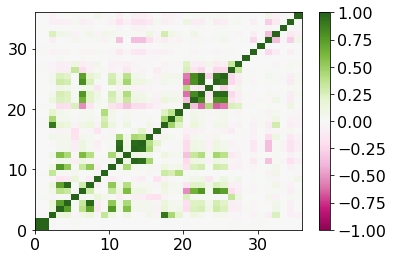

In [44]:
# Plot covariance matrix before filtering strong outliers
for i in range(0,len(data_cat.columns)): print(i,": ", data_cat.columns[i])
corrmat = np.corrcoef(data_cat,rowvar=False)
mpl.rcParams['font.size']=16
lab.figure(); lab.pcolor(corrmat,cmap='PiYG'); lab.colorbar(); lab.clim(-1,1)
lab.savefig(pathOUT + 'Covariances_beforefiltoutsiders.png')  
lab.show()

### 1.4 Filter out strongest outliers

In [45]:
# Filter out strong outliers (> 5-10 sigma) for numeric features
orisize = len(data_cat)
for col in data.columns: # update data_cat but don't run across cat variables
    #print("max: ",data_cat[col].max())
    k = 0; n = len(data_cat) # n changes as rows are deleted
    mean = data_cat[col].mean()
    sdev = data_cat[col].std()
    for i in range(0,n):
        if abs(data_cat[col].iloc[i-k] - mean) > 6 * sdev:      
            data_cat = data_cat.drop(data_cat.index[[i-k]])
            k += 1
    #print("max under 6 sigma: ",data_cat[col].max())
    print("Number of outliers filtered for {}: {} ({:.3f}%)".format(col, k, (k / orisize * 100)))
newsize = len(data_cat)
print("Number of observations: Original = ",orisize,", New = ",newsize) 

Number of outliers filtered for Unnamed: 0: 0 (0.000%)
Number of outliers filtered for Unnamed: 0.1: 0 (0.000%)
Number of outliers filtered for Past_Month_ProdA: 76 (0.472%)
Number of outliers filtered for Fcst_Next_Year_ProdA: 72 (0.447%)
Number of outliers filtered for Fcst_Next_CalendarYear_ProdA: 54 (0.335%)
Number of outliers filtered for DiscountValue: 2 (0.012%)
Number of outliers filtered for Fcst_Next_Year_ProdB: 16 (0.099%)
Number of outliers filtered for Paid_ProdA: 47 (0.292%)
Number of outliers filtered for Net_Margin_ProdB: 97 (0.603%)
Number of outliers filtered for NumberProd_Purchased: 26 (0.162%)
Number of outliers filtered for Net_Margin_Total: 37 (0.230%)
Number of outliers filtered for Loyalty: 1 (0.006%)
Number of outliers filtered for Subscription: 70 (0.435%)
Number of outliers filtered for time_activ: 0 (0.000%)
Number of outliers filtered for time_contract: 1 (0.006%)
Number of outliers filtered for time_modif_prod: 0 (0.000%)
Number of outliers filtered for t

### 1.5 After filtering above, re-compute marginal correlations and associations, and covariance matrix

Pearson correlation after filtering strong outsiders for churn: r = 1.000
Hamming dissimilarity between churn and sales channels for Price_ProdB_2yago: J = 1.000
Hamming dissimilarity between churn and sales channels for Price_ProdB_1yago: J = 0.466
Hamming dissimilarity between churn and sales channels for Price_ProdB: J = 0.466
Hamming dissimilarity between churn and sales channels for PriceChange_ProdA_2y1y: J = 1.000
Hamming dissimilarity between churn and sales channels for PriceChange_ProdB_2y1y: J = 0.917
Hamming dissimilarity between churn and sales channels for SalesChannel_epumfxlbckeskwekxbiuasklxalciiuu: J = 0.101
Hamming dissimilarity between churn and sales channels for SalesChannel_ewpakwlliwisiwduibdlfmalxowmwpci: J = 0.152
Hamming dissimilarity between churn and sales channels for SalesChannel_fixdbufsefwooaasfcxdxadsiekoceaa: J = 0.101
Hamming dissimilarity between churn and sales channels for SalesChannel_foosdfpfkusacimwkcsosbicdxkicaua: J = 0.451
Hamming dissimilar

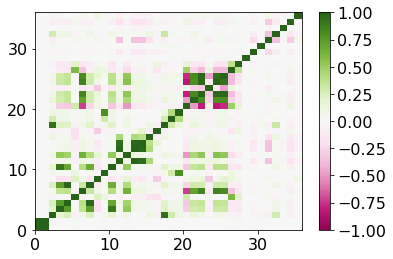

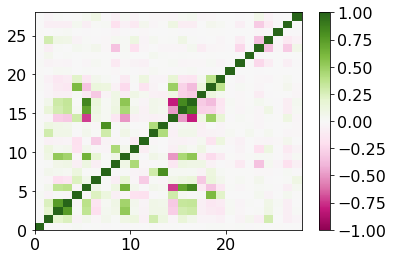

In [46]:
# Check marginal correlation after filtering strong outliers
for col in data_cat.columns:
    r = np.corrcoef(data_cat[col],data_cat['churn']) # check if marginal correlation is significant
    if abs(r[0,1]) > 0.1: print("Pearson correlation after filtering strong outsiders for {}: r = {:.3f}".format(col,r[0,1]))

# Hamming and Jaccard dissimilarity coefficient between between churn and sales channels
for col in data_cat.columns[-13:-1]:
    ha = sc.spatial.distance.hamming(data_cat[col],data_cat['churn']) # jaccard
    if abs(ha) > 0.1: print("Hamming dissimilarity between churn and sales channels for {}: J = {:.3f}".format(col,ha))

# Plot covariance matrix after filtering strong outliers
for i in range(0,len(data_cat.columns)): print(i,": ", data_cat.columns[i])
corrmat = np.corrcoef(data_cat,rowvar=False)
lab.figure(); lab.pcolor(corrmat,cmap='PiYG'); lab.colorbar(); lab.clim(-1,1)
lab.savefig(pathOUT + 'Covariances_afterfiltoutsiders.png') # lab.show()

# Reduce number of colinear features (r > 0.9)
i = 0
while i < len(data_cat.columns):
    corrmat = np.corrcoef(data_cat,rowvar=False)
    j = np.where(corrmat[i]>0.9)
    col = data_cat.columns[j]
    lcol = len(col)
    if lcol >= 2:
        print('Colinearity > 90% between: ', col[0],' ', end='')
        [print(col[k],' ', end='') for k in range(1,lcol)]; print('')
        for k in range(1,lcol):
            print('Deleting feature: ', col[k])
            data_cat = data_cat.drop([col[k]],axis=1)
    i += 1

# Plot covariance matrix after filtering colinear features
for i in range(0,len(data_cat.columns)): print(i,": ", data_cat.columns[i])
corrmat = np.corrcoef(data_cat,rowvar=False)
lab.figure(); lab.pcolor(corrmat,cmap='PiYG'); lab.colorbar(); lab.clim(-1,1)
lab.savefig(pathOUT + 'Covariances_afterfiltcolinear.png') 
lab.show()

# Write dataset with less outliers
data_cat.to_csv(pathIN + 'training_data_cat_clean_noout.csv') # -- WRITE TO TRAINING DATA ONLY

# Modeling

## 2. Develop ensemble of ML models

In this section, you will build several machine learning algorithms, including automatic feature selection and combining multiple models together to improve performance. 

### 2.1 Filter out features with high sparsity

In [47]:
'''
# Skip above loading time -- RESTART WITH TRAINING DATA ONLY
data_cat = pd.read_csv(pathIN + 'training_data_cat_clean_noout.csv')
data_cat = data_cat.drop(['Unnamed: 0.1'],axis=1) # to remove next time above is run
data_cat = data_cat.drop(['Unnamed: 0'],axis=1) # to remove next time above is run
'''

# Transform to np array
np_cat = data_cat.as_matrix() 
# np_nonan = nonan.as_matrix() 

positive = np_cat[np_cat[:,-1] == 1,:]
negative = np_cat[np_cat[:,-1] == 0,:]
print('Original total sizes: Pos = ',len(positive),' and Neg = ',len(negative))

# Filter out feature with very high sparsity (= pre-feature selection) by removing feature which have no variance across p% observations 
sel = VarianceThreshold(threshold=(.95 * (1 - .95))) # p(1 - p) is the variance of a Bernoulli variable
np_cat = sel.fit_transform(np_cat)
print("Number of features selected by variance threshold: {}".format(np_cat.shape[1] - 1)) # -1 if churn is in
features_fs1 = pd.DataFrame(data_cat.columns[sel.get_support(indices=True)[:-1]])
print(features_fs1.values) 

Original total sizes: Pos =  1513  and Neg =  13543
Number of features selected by variance threshold: 19
[['Unnamed: 0']
 ['Past_Month_ProdA']
 ['Fcst_Next_Year_ProdA']
 ['Fcst_Next_CalendarYear_ProdA']
 ['DiscountValue']
 ['Fcst_Next_Year_ProdB']
 ['Net_Margin_ProdB']
 ['NumberProd_Purchased']
 ['Loyalty']
 ['Subscription']
 ['time_modif_prod']
 ['time_renewal']
 ['ProdB_PerMonth']
 ['Cross_AandB']
 ['Price_ProdB_2yago']
 ['SalesChannel_ewpakwlliwisiwduibdlfmalxowmwpci']
 ['SalesChannel_foosdfpfkusacimwkcsosbicdxkicaua']
 ['SalesChannel_lmkebamcaaclubfxadlmueccxoimlema']
 ['SalesChannel_usilxuppasemubllopkaafesmlibmsdf']]


### 2.2 Split data in training and testing sets

In [48]:
# Hold out some of the data for testing
np.random.shuffle(np_cat) # random_state=0)
l = len(np_cat) * 3 // 10 # ~30% 
np_train = np_cat[:-l]
np_test = np_cat[-l:]

# Split X and Y in testing set, then scale X_test
X_test = np_test[:,:-1]
Y_test = np_test[:,-1]
sx = preprocessing.StandardScaler().fit(np_train[:,:-1]) # Try both np_cat[:,:-1] (all Xs) and np_train[:,:-1] (i.e. X_train) 
X_test = sx.transform(X_test)
X = sx.transform(np_cat[:,:-1]) # all Xs, used for K-fold cross validation
Y = np_cat[:,-1]               # all Ys, used for K-fold cross validation

# Define forecast data (actual forecast, i.e. for which there is no y label)
# Select same feature space as used in trained models
data_cat_fcst = pd.read_csv(pathIN + 'forecast_data_cat_clean.csv')
X_fcst  = data_cat_fcst[features_fs1.values[:,0]].as_matrix()
X_fcst = sx.transform(X_fcst) # defined based on training data


### 2.3 Balance datasets and run ML classifiers

In [49]:
if(balance):
    # Take random sample so to have balanced classes
    positive = np_train[np_train[:,-1] == 1,:]
    negative = np_train[np_train[:,-1] == 0,:]
    # positive_nonan = np_nonan[np_nonan[:,-1] == 1,:]
    # negative_nonan = np_nonan[np_nonan[:,-1] == 0,:]
    print('Original training sizes: Pos = ',len(positive),' and Neg = ',len(negative))
    # print('Only for clients with no NaN: Pos = ',len(positive_nonan),' and Neg = ',len(negative_nonan))

    if len(positive) > len(negative):

        # via under-sampling
        np.random.shuffle(positive)
        positive = positive[:len(negative)]

        # via over-sampling (NOT USED AS IT OVERFITS)
        #np.random.shuffle(negative)
        #neg = negative
        #boost = divmod(len(positive), len(negative))
        #for i in range(1,boost[0]): 
        #    negative = np.concatenate((negative,neg),axis=0)
        #negative = np.concatenate((negative,neg[:boost[1]]),axis=0)

    elif len(positive) < len(negative):

        # via under-sampling
        np.random.shuffle(negative)
        negative = negative[:len(positive)] 

        # via over-sampling (NOT USED AS IT OVERFITS)
        #np.random.shuffle(positive)
        #pos = positive
        #boost = divmod(len(negative), len(positive))
        #for i in range(1,boost[0]): 
        #    positive = np.concatenate((positive,pos),axis=0)
        #positive = np.concatenate((positive,pos[:boost[1]]),axis=0)

    # Re-assemble the training dataset
    np_train = np.concatenate((positive,negative),axis=0)
    print('Balanced sample sizes: Pos = ',len(positive),' and Neg = ',len(negative))

    # Shuffle the data 
    np.random.shuffle(np_train) 

# Split X and Y in training set, then scale X_train
X_train = np_train[:,:-1]
Y_train = np_train[:,-1] 
X_train = sx.transform(X_train)

# Train model
logit = LogisticRegression(class_weight={0:.6, 1:.4}) # class_weight={0:.6, 1:.4}) # class_weight = 'balanced') 
svm = SVC(class_weight={0:.6, 1:.4})
svm2 = SVC(probability=True,class_weight={0:.6, 1:.4})
rf = RandomForestClassifier(n_estimators=10, bootstrap=True,class_weight={0:.6, 1:.4})
#logit = CalibratedClassifierCV(logit, cv=10, method='isotonic')
#logit = CalibratedClassifierCV(logit, cv=10, method='sigmoid')
svm2 = CalibratedClassifierCV(svm2, cv=5, method='isotonic')
#svm2 = CalibratedClassifierCV(svm2, cv=10, method='sigmoid')
rf = CalibratedClassifierCV(rf, cv=5, method='isotonic')
#rf = CalibratedClassifierCV(rf, cv=10, method='sigmoid')  
ens = VotingClassifier(estimators=[('logit', logit), ('svm', svm2), ('rf', rf)], voting='soft')
#params = {'rf__n_estimators': [20, 200],'logit__class_weight':[{0: w} for w in [, 2, 4, 6, 10]]}
#grid = GridSearchCV(estimator=ens, param_grid=params, cv=5)

model_logit = logit.fit(X_train, Y_train)
model_svm   = svm.fit(X_train, Y_train)
model_svm2  = svm2.fit(X_train, Y_train)
model_rf    = rf.fit(X_train, Y_train)
model_ens    = ens.fit(X_train, Y_train)
#model_ens    = grid.fit(X_train, Y_train)

# Use model
Y_pred_logit = model_logit.predict(X_test)
Y_pred_svm = model_svm.predict(X_test)
Y_pred_rf = model_rf.predict(X_test)
Y_pred_ens = model_ens.predict(X_test)
coefficients = pd.concat([pd.DataFrame(features_fs1.values),pd.DataFrame(np.transpose(model_logit.coef_))], axis = 1)
print("\n Coefficients Logit: \n", coefficients)

# Compute probability of churn
Y_prob_logit = model_logit.predict_proba(X_test)
Y_prob_svm = model_svm2.predict_proba(X_test)
Y_prob_rf = model_rf.predict_proba(X_test)
Y_prob_ens = model_ens.predict_proba(X_test)


Original training sizes: Pos =  1079  and Neg =  9461
Balanced sample sizes: Pos =  1079  and Neg =  1079


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



 Coefficients Logit: 
                                                 0         0
0                                      Unnamed: 0 -0.034677
1                                Past_Month_ProdA -0.131878
2                            Fcst_Next_Year_ProdA  0.344164
3                    Fcst_Next_CalendarYear_ProdA -0.058865
4                                   DiscountValue -0.121476
5                            Fcst_Next_Year_ProdB  0.184391
6                                Net_Margin_ProdB  0.444475
7                            NumberProd_Purchased  0.023858
8                                         Loyalty -0.246634
9                                    Subscription -0.272088
10                                time_modif_prod  0.024216
11                                   time_renewal  0.076705
12                                 ProdB_PerMonth  0.013532
13                                    Cross_AandB -0.122508
14                              Price_ProdB_2yago  0.094446
15  SalesChannel

# Evaluation

## 3. Evaluate and refine ML model performance

In this section, you will test the performance of the different models developed and identify a decision-making mechanism that minimizes the risk of over estimating the number of customers who will churn. You will also run a stepwise recursive regression to identify and rank feature importance.

Number of features selected by stepwise learning: 15
[['Past_Month_ProdA']
 ['Fcst_Next_Year_ProdA']
 ['Fcst_Next_CalendarYear_ProdA']
 ['DiscountValue']
 ['Fcst_Next_Year_ProdB']
 ['Net_Margin_ProdB']
 ['Loyalty']
 ['Subscription']
 ['time_renewal']
 ['Cross_AandB']
 ['Price_ProdB_2yago']
 ['SalesChannel_ewpakwlliwisiwduibdlfmalxowmwpci']
 ['SalesChannel_foosdfpfkusacimwkcsosbicdxkicaua']
 ['SalesChannel_lmkebamcaaclubfxadlmueccxoimlema']
 ['SalesChannel_usilxuppasemubllopkaafesmlibmsdf']]


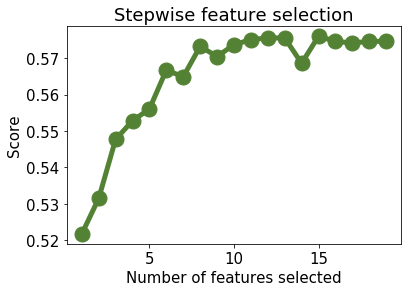


 Model: logit
ROC AUC score: 0.631
Brier score: 0.174
Classification rate: 0.809
         Pred Neg  Pred Pos
Obs Neg     86.6%     13.4%
Obs Pos     72.4%     27.6% 


 Model: stepwise
ROC AUC score: 0.630
Brier score: 0.174
Classification rate: 0.813
         Pred Neg  Pred Pos
Obs Neg     86.9%     13.1%
Obs Pos     71.7%     28.3% 


 Model: svm
ROC AUC score: 0.626
Brier score: 0.236
Classification rate: 0.851
         Pred Neg  Pred Pos
Obs Neg     92.7%      7.3%
Obs Pos     85.9%     14.1% 


 Model: rf
ROC AUC score: 0.646
Brier score: 0.240
Classification rate: 0.653
         Pred Neg  Pred Pos
Obs Neg     66.5%     33.5%
Obs Pos     46.1%     53.9% 


 Model: ens
ROC AUC score: 0.646
Brier score: 0.209
Classification rate: 0.745
         Pred Neg  Pred Pos
Obs Neg     78.1%     21.9%
Obs Pos     59.7%     40.3% 



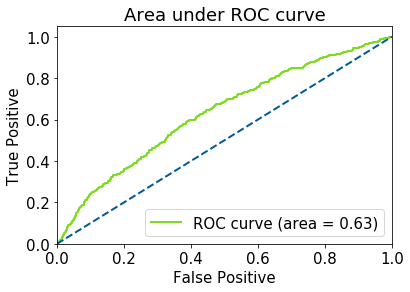

In [50]:
# Use recursive/stepwise feature selection
stepwise = RFECV(estimator=logit, step=1)
model_stepwise = stepwise.fit(X_train, Y_train)
print("Number of features selected by stepwise learning: %d" % stepwise.n_features_)
Y_pred_stepwise = model_stepwise.predict(X_test)
Y_prob_stepwise = model_stepwise.predict_proba(X_test)
features_fs2 = pd.DataFrame(features_fs1.values[model_stepwise.get_support(indices=True)])
print(features_fs2.values)

#Plot number of features vs. cross-validation scores
plt.figure()
mpl.rcParams['font.size']=15
plt.xlabel("Number of features selected")
plt.ylabel("Score")
plt.title("Stepwise feature selection")
plt.plot(range(1, len(stepwise.grid_scores_) + 1), stepwise.grid_scores_, color='#548235',marker='o',lw=5,markersize=15)
plt.savefig(pathOUT + 'StepwiseFeatSel_Classification.png') 
plt.show()
plt.close()

# Assess performance

# Classification rate 
p_logit = accuracy_score(Y_test, Y_pred_logit)
p_stepwise = accuracy_score(Y_test, Y_pred_stepwise)
p_svm = accuracy_score(Y_test, Y_pred_svm)
p_rf = accuracy_score(Y_test, Y_pred_rf)
p_ens = accuracy_score(Y_test, Y_pred_ens)

# Brier score
b_logit = brier_score_loss(Y_test, Y_prob_logit[:,1])
b_stepwise = brier_score_loss(Y_test, Y_prob_stepwise[:,1])
b_svm = brier_score_loss(Y_test, Y_prob_svm[:,1])
b_rf = brier_score_loss(Y_test, Y_prob_rf[:,1])
b_ens = brier_score_loss(Y_test, Y_prob_ens[:,1])

# ROC AUC score
roc_logit = roc_auc_score(Y_test, Y_prob_logit[:,1]) 
roc_stepwise = roc_auc_score(Y_test, Y_prob_stepwise[:,1]) 
roc_svm = roc_auc_score(Y_test, Y_prob_svm[:,1]) 
roc_rf = roc_auc_score(Y_test, Y_prob_rf[:,1]) 
roc_ens = roc_auc_score(Y_test, Y_prob_ens[:,1]) 

for m in ['logit', 'stepwise', 'svm', 'rf', 'ens']:
    Y_pred = eval('Y_pred_' + m)
    p = eval('p_' + m) 
    b = eval('b_' + m)    
    roc = eval('roc_' + m) 
    tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred).ravel()    
    print("\n Model: {}".format(m))
    print("ROC AUC score: {:.3f}".format(roc))
    print("Brier score: {:.3f}".format(b))
    print("Classification rate: {:.3f}".format(p))
    print("{0:>17}{1:>10}".format("Pred Neg", "Pred Pos"))
    print("{0:<12}{1:<4.1f}%{2:>9.1f}%".format("Obs Neg", tn/(tn+fp)*100, fp/(tn+fp)*100))
    print("{0:<12}{1:<4.1f}%{2:>9.1f}% \n".format("Obs Pos", fn/(tp+fn)*100, tp/(tp+fn)*100))

# Plot ROC AUC
roc_auc = dict()
fpr, tpr, _ = roc_curve(Y_test, Y_prob_logit[:, 1])  
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='#7DDC1F', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='#005B96', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.title('Area under ROC curve')
plt.legend(loc="lower right")
plt.savefig(pathOUT + 'roc.png') 
plt.show()
plt.close()

# Assess performance via K-folding
kfold = model_selection.KFold(n_splits=10, random_state=0)
cv_results = model_selection.cross_val_score(ens, X, Y, cv=kfold)
cvsc = cv_results.sum() / 10
print("\n Average accuracy over 10 folds: \n",cvsc)
print("\n Score in each fold: \n",cv_results)


# Application

## 4. Apply ML models and sensitivity analysis to design a strategy


In this section, you will use the ML results from other sections to better understand the factors that impact customer churn, derive strategic options, and quantitatively evaluate the impact on churn if one were to move forward with these options. This will be done by what is called a sensitivity analysis, where you'll modify some factors that can be controlled in real life (such as the discount rate) and predict the reduction in churn expected for different values of this control factor. All predictions will be made with the best ML model identified in the previous section.

In [51]:
# FORECASTS === ACTUAL ===

# Churn vs. No Churn
Y_fcst_logit = model_logit.predict(X_fcst)
Y_fcst_svm = model_svm.predict(X_fcst)
Y_fcst_rf = model_rf.predict(X_fcst)
Y_fcst_ens = model_ens.predict(X_fcst)
Y_fcst_stepwise = model_stepwise.predict(X_fcst)

# Probability of Churn
Y_fcst_prob_logit = model_logit.predict_proba(X_fcst)
Y_fcst_prob_svm = model_svm2.predict_proba(X_fcst)
Y_fcst_prob_rf = model_rf.predict_proba(X_fcst)
Y_fcst_prob_ens = model_ens.predict_proba(X_fcst)
Y_fcst_prob_stepwise = model_stepwise.predict_proba(X_fcst)

# % churn
for m in ['logit', 'stepwise', 'svm', 'rf', 'ens']:
    labels = eval('Y_fcst_' + m)
    pc = labels.sum()/len(labels) * 100
    print("From {0:}: churn = {1:<5.2f}%".format(m,pc))

# Sensitivity analysis
disc = 3 # Indices: 3 = Discount Value, could control for other features such as prices or margins 
m = 'logit' # 'logit', 'stepwise', 'svm', 'rf', 'ens'
print('Sensitivity Analysis - Discount based on: ',features_fs1.values[disc,0])
print(' Model use to identify churn: ',m)
l = eval('Y_fcst_prob_' + m)
for d in range(10,50,10):
        for i in range(0,len(l)): 
            if (l[i,1] > 0.6 and X_fcst[i,3] < d):   # Using threshold of .6 means we only identify ~25% of churn, but enables fall out < 10%
                if disc == 3: 
                    X_fcst[i,disc] = float(d)                               
                else: 
                    X_fcst[i,disc] = X_fcst[i,disc] * (1 - float(d)/100) 
        print("Add {}% discount".format(d))

        # Churn vs. No Churn
        Y_fcst_logit = model_logit.predict(X_fcst)
        Y_fcst_svm = model_svm.predict(X_fcst)
        Y_fcst_rf = model_rf.predict(X_fcst)
        Y_fcst_ens = model_ens.predict(X_fcst)
        Y_fcst_stepwise = model_stepwise.predict(X_fcst)

        # % churn
        for m in ['logit', 'stepwise', 'svm', 'rf', 'ens']:
            label = eval('Y_fcst_' + m)
            pc = label.sum()/len(label) * 100
            print("From {0:}: churn = {1:<5.2f}%".format(m,pc))     


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


From logit: churn = 16.60%
From stepwise: churn = 14.21%
From svm: churn = 7.60 %
From rf: churn = 37.40%
From ens: churn = 24.13%
Sensitivity Analysis - Discount based on:  Fcst_Next_CalendarYear_ProdA
 Model use to identify churn:  logit
Add 10% discount


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


From logit: churn = 14.89%
From stepwise: churn = 11.98%
From svm: churn = 4.55 %
From rf: churn = 37.48%
From ens: churn = 23.86%
Add 20% discount


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


From logit: churn = 12.75%
From stepwise: churn = 10.34%
From svm: churn = 4.55 %
From rf: churn = 37.48%
From ens: churn = 20.90%
Add 30% discount


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


From logit: churn = 12.05%
From stepwise: churn = 9.59 %
From svm: churn = 4.55 %
From rf: churn = 37.48%
From ens: churn = 19.86%
Add 40% discount
From logit: churn = 11.75%
From stepwise: churn = 9.32 %
From svm: churn = 4.55 %
From rf: churn = 37.48%
From ens: churn = 19.41%


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# Addendum

## Refinement of model performance with Ensemble Modeling

9  sub-samples ... learning from sub-sample  1


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


9  sub-samples ... learning from sub-sample  2
9  sub-samples ... learning from sub-sample  3
9  sub-samples ... learning from sub-sample  4
9  sub-samples ... learning from sub-sample  5
9  sub-samples ... learning from sub-sample  6
9  sub-samples ... learning from sub-sample  7
9  sub-samples ... learning from sub-sample  8
9  sub-samples ... learning from sub-sample  9
From logit: churn = 25.55%
From svm: churn = 19.58%
From rf: churn = 9.59 %
From ens: churn = 18.56%

 Model: logit
ROC AUC score: 0.637
Brier score: 0.256
Classification rate: 0.700
         Pred Neg  Pred Pos
Obs Neg     72.7%     27.3%
Obs Pos     55.1%     44.9% 


 Model: svm
ROC AUC score: 0.700
Brier score: 0.248
Classification rate: 0.756
         Pred Neg  Pred Pos
Obs Neg     78.5%     21.5%
Obs Pos     52.1%     47.9% 


 Model: rf
ROC AUC score: 0.817
Brier score: 0.241
Classification rate: 0.858
         Pred Neg  Pred Pos
Obs Neg     89.6%     10.4%
Obs Pos     50.0%     50.0% 


 Model: ens
ROC AUC sco

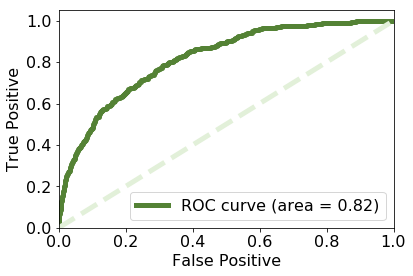

In [52]:
#################################
#                               #
#     Custom Ensemble Model     #
#                               #
#################################

# Use ensemble approach to deal with unbalanced distribution of classes (churn = 10% of clients)

# Redefine np_train as it was before balancing (needed in case balancing was applied)
np_train = np_cat[:-1]

# Positive class is ~9 times smaller than negative class, so let's design a 9-fold ensemble
nsamples = 9
positive = np_train[np_train[:,-1] == 1]
negative = np_train[np_train[:,-1] == 0]     
s = len(positive)
for i in range(0,nsamples):
    print(nsamples,' sub-samples ... learning from sub-sample ',i+1)
    np_train_sub = np.concatenate((positive,negative[i*s:(i+1)*s]),axis=0)
    np.random.shuffle(np_train_sub)

    # Define and scal X_train  
    X_train = np_train_sub[:,:-1]
    sxt = preprocessing.StandardScaler().fit(X_train)
    X_train = sxt.transform(X_train)

    # Define Y 
    Y_train = np_train_sub[:,-1] 

    # Train model
    logit = LogisticRegression() #class_weight={0:.7, 1:.3}) # 'balanced') 
    svm = SVC()
    svm2 = SVC(probability=True)
    rf = RandomForestClassifier(n_estimators=10, bootstrap=True)
    #logit = CalibratedClassifierCV(logit, cv=10, method='isotonic')
    #logit = CalibratedClassifierCV(logit, cv=10, method='sigmoid')
    svm2 = CalibratedClassifierCV(svm2, cv=2, method='isotonic')
    #svm2 = CalibratedClassifierCV(svm2, cv=10, method='sigmoid')
    rf = CalibratedClassifierCV(rf, cv=2, method='isotonic')
    #rf = CalibratedClassifierCV(rf, cv=10, method='sigmoid')  
    ens = VotingClassifier(estimators=[('logit', logit), ('svm', svm2), ('rf', rf)], voting='soft')     
    model_logit = logit.fit(X_train, Y_train)
    model_svm   = svm.fit(X_train, Y_train)
    model_svm2  = svm2.fit(X_train, Y_train)
    model_rf    = rf.fit(X_train, Y_train)
    model_ens   = ens.fit(X_train, Y_train)

    # Compute probability of churn
    if i == 0:
        # Training/testing
        Y_pred_logit = model_logit.predict(X_test)
        Y_pred_svm = model_svm.predict(X_test)
        Y_pred_rf = model_rf.predict(X_test)
        Y_pred_ens = model_ens.predict(X_test)
        Y_prob_logit = model_logit.predict_proba(X_test)
        Y_prob_svm = model_svm2.predict_proba(X_test)
        Y_prob_rf = model_rf.predict_proba(X_test)
        Y_prob_ens = model_ens.predict_proba(X_test)
        # Actual forecasts
        Y_fcst_logit = model_logit.predict(X_fcst)
        Y_fcst_svm = model_svm.predict(X_fcst)
        Y_fcst_rf = model_rf.predict(X_fcst)
        Y_fcst_ens = model_ens.predict(X_fcst)
        Y_fcst_prob_logit = model_logit.predict_proba(X_fcst)
        Y_fcst_prob_svm = model_svm2.predict_proba(X_fcst)
        Y_fcst_prob_rf = model_rf.predict_proba(X_fcst)
        Y_fcst_prob_ens = model_ens.predict_proba(X_fcst)                
    else:
        # Training/testing
        Y_prob_logit = Y_prob_logit + model_logit.predict_proba(X_test)
        Y_prob_svm = Y_prob_svm + model_svm2.predict_proba(X_test)
        Y_prob_rf = Y_prob_rf + model_rf.predict_proba(X_test)
        Y_prob_ens = Y_prob_ens + model_ens.predict_proba(X_test)
        # Actual forecasts
        Y_fcst_prob_logit = Y_fcst_prob_logit + model_logit.predict_proba(X_fcst)
        Y_fcst_prob_svm = Y_fcst_prob_svm + model_svm2.predict_proba(X_fcst)
        Y_fcst_prob_rf = Y_fcst_prob_rf + model_rf.predict_proba(X_fcst)
        Y_fcst_prob_ens = Y_fcst_prob_ens + model_ens.predict_proba(X_fcst)

# Compute average predicted probability over ensemble of classifiers from each sub-sample
# Training/testing
Y_prob_logit = Y_prob_logit / nsamples
Y_prob_svm = Y_prob_svm / nsamples
Y_prob_rf = Y_prob_rf / nsamples
Y_prob_ens = Y_prob_ens / nsamples
# Actual forecasts
Y_fcst_prob_logit = Y_fcst_prob_logit / nsamples
Y_fcst_prob_svm = Y_fcst_prob_svm / nsamples
Y_fcst_prob_rf = Y_fcst_prob_rf / nsamples
Y_fcst_prob_ens = Y_fcst_prob_ens / nsamples

# Training/testing
for i in range(0,len(Y_test)):
    threshold = 0.56 # probability threshold for positive class (churn)
    # logit
    if Y_prob_logit[i][1] > threshold: 
        Y_pred_logit[i] = 1.
    else:
        Y_pred_logit[i] = 0.
    # svm
    if Y_prob_svm[i][1] > threshold: 
        Y_pred_svm[i] = 1.
    else:
        Y_pred_svm[i] = 0.
    # rf
    if Y_prob_rf[i][1] > threshold: 
        Y_pred_rf[i] = 1.
    else:
        Y_pred_rf[i] = 0.
    # ensemble
    if Y_prob_ens[i][1] > threshold: 
        Y_pred_ens[i] = 1.
    else:
        Y_pred_ens[i] = 0.

# Actual forecasts
for i in range(0,len(X_fcst)):
    threshold = 0.56 # probability threshold for positive class (churn)
    # logit
    if Y_fcst_prob_logit[i][1] > threshold: 
        Y_fcst_logit[i] = 1.
    else:
        Y_fcst_logit[i] = 0.
    # svm
    if Y_fcst_prob_svm[i][1] > threshold: 
        Y_fcst_svm[i] = 1.
    else:
        Y_fcst_svm[i] = 0.
    # rf
    if Y_fcst_prob_rf[i][1] > threshold: 
        Y_fcst_rf[i] = 1.
    else:
        Y_fcst_rf[i] = 0.
    # ensemble
    if Y_fcst_prob_ens[i][1] > threshold: 
        Y_fcst_ens[i] = 1.
    else:
        Y_fcst_ens[i] = 0.

# % churn
for m in ['logit', 'svm', 'rf', 'ens']:
    label = eval('Y_fcst_' + m)
    pc = label.sum()/len(label) * 100
    print("From {0:}: churn = {1:<5.2f}%".format(m,pc))   

# Assess performance
# Classification rate 
p_logit = accuracy_score(Y_test, Y_pred_logit)
p_svm = accuracy_score(Y_test, Y_pred_svm)
p_rf = accuracy_score(Y_test, Y_pred_rf)
p_ens = accuracy_score(Y_test, Y_pred_ens)
# Full report available (not printed though:)
rep_logit = classification_report(Y_test, Y_pred_logit) # available but not printed
rep_svm = classification_report(Y_test, Y_pred_svm)     # available but not printed
rep_rf = classification_report(Y_test, Y_pred_rf)       # available but not printed
# Brier score
b_logit = brier_score_loss(Y_test, Y_prob_logit[:,1])
b_svm = brier_score_loss(Y_test, Y_prob_svm[:,1])
b_rf = brier_score_loss(Y_test, Y_prob_rf[:,1])
b_ens = brier_score_loss(Y_test, Y_prob_ens[:,1])
# ROC AUC score
roc_logit = roc_auc_score(Y_test, Y_prob_logit[:,1])  
roc_svm = roc_auc_score(Y_test, Y_prob_svm[:,1]) 
roc_rf = roc_auc_score(Y_test, Y_prob_rf[:,1]) 
roc_ens = roc_auc_score(Y_test, Y_prob_ens[:,1]) 

for m in ['logit', 'svm', 'rf', 'ens']:
    Y_pred = eval('Y_pred_' + m)
    p = eval('p_' + m) 
    b = eval('b_' + m)    
    roc = eval('roc_' + m) 
    tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred).ravel()    
    print("\n Model: {}".format(m))
    print("ROC AUC score: {:.3f}".format(roc))
    print("Brier score: {:.3f}".format(b))
    print("Classification rate: {:.3f}".format(p))
    print("{0:>17}{1:>10}".format("Pred Neg", "Pred Pos"))
    print("{0:<12}{1:<4.1f}%{2:>9.1f}%".format("Obs Neg", tn/(tn+fp)*100, fp/(tn+fp)*100))
    print("{0:<12}{1:<4.1f}%{2:>9.1f}% \n".format("Obs Pos", fn/(tp+fn)*100, tp/(tp+fn)*100))

# Plot ROC AUC
roc_auc = dict()
fpr, tpr, _ = roc_curve(Y_test, Y_prob_rf[:, 1])  
roc_auc = auc(fpr, tpr)
plt.figure()
mpl.rcParams['font.size']=16
plt.plot(fpr, tpr, color='#548235', lw=5, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='#E2F0D9', lw=5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive')
plt.ylabel('True Positive')
#plt.title('Area under ROC curve')
plt.legend(loc="lower right")
plt.savefig(pathOUT + 'roc_ensemble.png') 
plt.show()
